<a href="https://colab.research.google.com/github/threegenie/churn_project/blob/main/telco_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **이 데이터를 선택한 이유 ?**
캐글에서 다양한 데이터를 찾던 중, 'Telco Customer Churn'이라는 데이터셋을 보게 되었습니다. 

최근에 핸드폰을 사용하면서 요금제 관련 불편한 점 때문에 기존에 오래 사용하던 통신사가 아닌 다른 통신사의 요금제로 바꾼 경험이 있었기 때문에, 관심이 생기는 주제였습니다. 

사람들이 통신사를 바꾸게 될 때 단순히 불편해서만이 아닌, 보편적인 이유가 있을지 궁금해져서 여러 특성들을 통해 통신사 변경 여부를 예측하는 모델을 만들어 보려고 합니다.

### **특성 설명**

* Gender : 성별 

* SeniorCitizen : 고령 여부 

* Partner : 배우자 유무 

* Dependents : 부양가족 유무 

* Tenure : 직장 근속 개월수 

* PhoneService : 전화 서비스 여부 

* MultipleLines : 다중 회선 여부

* InternetService : 인터넷 공급자 
  *  DSL
  *  Fiber optic

* OnlineSecurity : 온라인 보안 서비스 이용 여부

* OnlineBackup : 온라인 백업 서비스 이용 여부

* DeviceProtection : 기기보호 서비스 이용 여부

* TechSupport : 기술지원 서비스 이용 여부 

* StreamingTV : TV채널 스트리밍 이용 여부

* StreamingMovies : 영화 스트리밍 이용 여부 

* Contract : 계약 기간 
  * Month-to-Month 
  * One year 
  * Two year

* PaperlessBilling : 종이 고지서 신청 여부

* PaymentMethod : 요금 지불 방법
  * Electronic check
  * Bank transfer (automatic)
  * Mailed check
  * Credit card (automatic)

* MonthlyCharges : 월별 요금 

* TotalCharges : 총 요금 

* Churn : 이용자 서비스 해지 여부

In [2]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install catboost

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Telco-Customer-Churn.csv')
df = df.drop('customerID',axis=1)
df.head()

Mounted at /content/drive


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


예측할 특성은 Churn, 즉 서비스 이용자가 통신사를 변경했는지의 여부입니다. 타겟의 특성이 yes/no로 이루어져 있기 때문에, 분류 모델을 이용해 이 문제를 해결할 것입니다.

모든 분류 건수 중에서 분류기가 몇 개의 정답을 맞췄는지의 여부를 파악할 필요가 있기 때문에 Accuracy를 사용할 것입니다. 그리고 Accuracy의 단점을 보완하기 위해 추가로 F1 Score를 사용하여 모델의 성능을 평가하려고 합니다.

시계열 데이터가 아니기 때문에, 무작위로 데이터를 분리하여 훈련/검증/테스트 데이터셋을 만드는 방법을 택할 것입니다.

In [5]:
def processing(df):
  #TotalCharges - 숫자형인데 object로 표시되는 데이터를 numeric화
  df['TotalCharges'] = df['TotalCharges'].str.replace('.','')
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

  #Contract - 문자로 되어있는 계약 기간을 바꾸기
  mapping = {'Month-to-month':0,'One year':1,'Two year':2}
  df['Contract'] = df['Contract'].replace(mapping)

  #MultipleLines - yes / no / no phone service를 숫자로 바꾸기
  mapping2 = {'No phone service':0,'No':1,'Yes':2}
  df['MultipleLines'] = df['MultipleLines'].replace(mapping2)

  #그 외 yes/no/no internet service를 항목으로 가지는 특성들 숫자로 바꾸기
  mapping3 = {'No internet service':0,'No':1,'Yes':2}
  no_internet_feature = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
  df[no_internet_feature] = df[no_internet_feature].replace(mapping3)

  #Chrun - yes/no를 숫자로 바꾸기
  mapping4 = {'No':0,'Yes':1}
  df['Churn'] = df['Churn'].replace(mapping4)

processing(df)

**만들 수 있는 특성**
1. 배우자와 부양가족이 모두 있는지 여부
2. 온라인 보안, 백업 서비스를 모두 사용하는지 여부
3. tv채널과 영화 스트리밍 서비스를 모두 이용하는지 여부
4. 계약 기간별 월별 요금

In [6]:
def features(df):
  #배우자와 부양가족이 모두 있는지 여부 - Yes : 1, No : 0
  df['Family'] = np.where((df['Partner']==1) & (df['Dependents']==1),1,0)

  #온라인 보안, 백업 서비스를 모두 이용하는지 여부
  df['OnlineService'] = np.where((df['OnlineSecurity']==2) & (df['OnlineBackup']==2),1,0)

  #tv채널과 영화 스트리밍 서비스를 모두 이용하는지 여부
  df['StreamingService'] = np.where((df['StreamingTV']==2) & (df['StreamingMovies']==2),1,0)

  #온라인, 스트리밍 서비스를 모두 이용하는지 여부
  df['FullService'] = np.where((df['OnlineService']==1) & (df['StreamingService']==1),1,0)


features(df)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Family,OnlineService,StreamingService,FullService
0,Female,0,Yes,No,1,No,0,DSL,1,2,1,1,1,1,0,Yes,Electronic check,29.85,2985.0,0,0,0,0,0
1,Male,0,No,No,34,Yes,1,DSL,2,1,2,1,1,1,1,No,Mailed check,56.95,188950.0,0,0,0,0,0
2,Male,0,No,No,2,Yes,1,DSL,2,2,1,1,1,1,0,Yes,Mailed check,53.85,10815.0,1,0,1,0,0
3,Male,0,No,No,45,No,0,DSL,2,1,2,2,1,1,1,No,Bank transfer (automatic),42.30,184075.0,0,0,0,0,0
4,Female,0,No,No,2,Yes,1,Fiber optic,1,1,1,1,1,1,0,Yes,Electronic check,70.70,15165.0,1,0,0,0,0


> 고객당 월별 요금이 가장 높은 지불 방법

In [7]:
monthly_charges_by_pay_method = df.groupby(['PaymentMethod']).mean()[['MonthlyCharges']].reset_index()
monthly_charges_by_pay_method.head()

,PaymentMethod,MonthlyCharges
0,Bank transfer (automatic),67.192649
1,Credit card (automatic),66.512385
2,Electronic check,76.255814
3,Mailed check,43.917060


Text(0.5, 1.0, 'Monthly Charges by Payment Method')

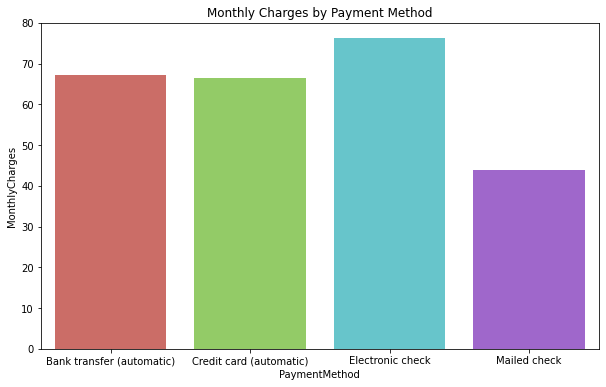

In [8]:
plt.figure(figsize = (10, 6))
sns.barplot(x='PaymentMethod',y='MonthlyCharges',data=monthly_charges_by_pay_method, palette='hls')
plt.title('Monthly Charges by Payment Method')

> 월별 요금에 따른 통신사 이적 여부

Text(0.5, 1.0, 'Customer Churn by Monthly Charges')

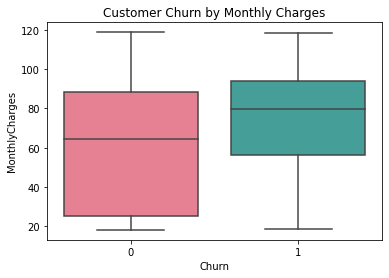

In [9]:
sns.boxplot(
    x = 'Churn',
    y = 'MonthlyCharges',
    data = df,
    palette='husl'
)
plt.title('Customer Churn by Monthly Charges')

> 성별에 따른 총 요금 분포

Text(0.5, 1.0, 'Total Charges by Gender')

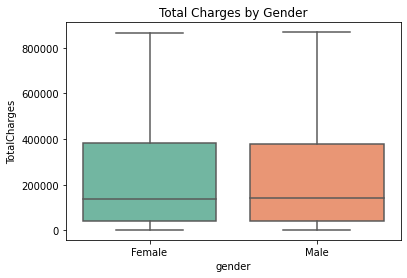

In [10]:
sns.boxplot(
    x = 'gender',
    y = 'TotalCharges',
    data = df,
    palette='Set2'
)
plt.title('Total Charges by Gender')

> 온라인 서비스를 사용하는 사람들의 통신사 이적 비율

Text(0.5, 1.0, 'Churn by Online Services')

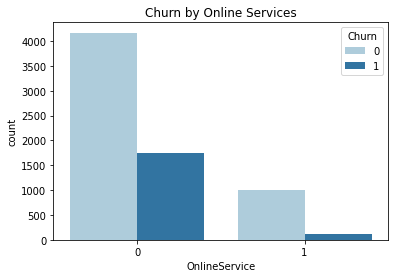

In [11]:
sns.countplot(x='OnlineService',hue = 'Churn',data=df,palette='Paired')
plt.title('Churn by Online Services')

> 스트리밍 서비스를 사용하는 사람들의 통신사 이적 비율

Text(0.5, 1.0, 'Churn by Streaming Services')

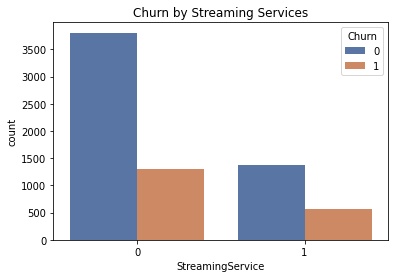

In [12]:
sns.countplot(x='StreamingService',hue = 'Churn',data=df,palette='deep')
plt.title('Churn by Streaming Services')

In [13]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.1, random_state=2)
train, test = train_test_split(train, test_size=0.05, random_state=2)
train.shape, val.shape, test.shape

((6021, 24), (705, 24), (317, 24))

In [14]:
target = 'Churn'
features = ['gender', 'SeniorCitizen', 'tenure','PhoneService', 'MultipleLines', 
            'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
            'PaperlessBilling', 'PaymentMethod','MonthlyCharges', 'TotalCharges',
            'Family','OnlineService','StreamingService','FullService']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

> 타겟 특성의 비율을 알아보고, 가중치 부여하기

In [15]:
y_train.value_counts(normalize=True)

0    0.731274
1    0.268726
Name: Churn, dtype: float64

In [16]:
#가중치
ratio = 0.26/0.73
ratio

0.35616438356164387





> Baseline




In [17]:
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
import lightgbm as lgb
from lightgbm import LGBMClassifier

pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
print('정확도(Accuracy): ', metrics.accuracy_score(y_val, y_pred))
print('F1 Score: ', metrics.f1_score(y_val, y_pred, average="binary"))

훈련 정확도:  0.9973426341139345
검증 정확도:  0.8056737588652483
정확도(Accuracy):  0.8056737588652483
F1 Score:  0.5324232081911262




> permutation importance를 통한 feature 선택



In [18]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe.named_steps['rf'],
    scoring='accuracy',
    n_iter=5, 
    random_state=2
)

X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)
permuter.fit(X_val_transformed, y_val);

eli5.show_weights(
    permuter, 
    top=None,
    feature_names=features 
)

Weight,Feature
0.0153 ± 0.0210,tenure
0.0130 ± 0.0104,Contract
0.0122 ± 0.0195,TotalCharges
0.0105 ± 0.0077,gender
0.0074 ± 0.0143,InternetService
0.0074 ± 0.0068,MultipleLines
0.0037 ± 0.0109,PaymentMethod
0.0034 ± 0.0149,SeniorCitizen
0.0031 ± 0.0068,OnlineService
0.0020 ± 0.0121,StreamingService


In [19]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
feature = X_train.columns[mask]
X_train_selected = X_train[feature]
X_val_selected = X_val[feature]

In [20]:
feature

Index(['gender', 'SeniorCitizen', 'tenure', 'MultipleLines', 'InternetService',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'OnlineService', 'StreamingService'],
      dtype='object')

In [21]:
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]



> hyperparameter tuning



RandomForest Model

In [ ]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'simpleimputer__strategy':['mean','median','most_frequent'],
    "randomforestclassifier__n_estimators": list(range(10, 1000, 100)),
    "randomforestclassifier__max_depth": list(range(2,10,2)),
    "randomforestclassifier__max_features": list(range(3,12,3)),
    "randomforestclassifier__min_samples_split": list(range(3,9,2))
}

model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier()
)

search = RandomizedSearchCV(
    model, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2,
)

search.fit(X_train, y_train);
model = search.best_estimator_
y_val_pred = model.predict(X_val)

print('\n최적 하이퍼파라미터: ', search.best_params_)
print('Accuracy: ', metrics.accuracy_score(y_val, y_val_pred))
print('f1 score: ', metrics.f1_score(y_val, y_val_pred, average='binary'))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1705s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (15.2065s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.6s


LGBM model

In [30]:
param_distributions = { 
    "lgbmclassifier__n_estimators": list(range(10, 1000, 100)),
    "lgbmclassifier__max_depth": list(range(2,10,2)),
    "lgbmclassifier__max_features": list(range(3,12,3)),
    "lgbmclassifier__min_samples_split": list(range(3,9,2)),
    "lgbmclassifier__num_iterations":list(range(100,1000,100))

}

model_lgbm = make_pipeline(
    OrdinalEncoder(), 
    LGBMClassifier(scale_pos_weight = ratio,learning_rate=0.1)
)

search_lgbm = RandomizedSearchCV(
    model_lgbm, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2
)

search_lgbm.fit(X_train, y_train);
model_lgbm = search.best_estimator_
y_val_pred = model_lgbm.predict(X_val)

print('\n최적 하이퍼파라미터: ', search_lgbm.best_params_)
print('Accuracy: ', metrics.accuracy_score(y_val, y_val_pred))
print('f1 score: ', metrics.f1_score(y_val, y_val_pred, average='binary'))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1


최적 하이퍼파라미터:  {'lgbmclassifier__num_iterations': 300, 'lgbmclassifier__n_estimators': 310, 'lgbmclassifier__min_samples_split': 3, 'lgbmclassifier__max_features': 6, 'lgbmclassifier__max_depth': 8}
Accuracy:  0.8212765957446808
f1 score:  0.5625000000000001


XGBClassifier model

In [31]:
from xgboost import XGBClassifier

param_distributions = { 
    "xgbclassifier__n_estimators": list(range(10, 1000, 100)),
    "xgbclassifier__max_depth": list(range(2,10,2)),
    "xgbclassifier__max_features": list(range(3,12,3)),
    "xgbclassifier__min_samples_split": list(range(3,9,2)),
    "xgbclassifier__num_iterations":list(range(100,1000,100))

}

model_xgb = make_pipeline(
    OrdinalEncoder(), 
    XGBClassifier(scale_pos_weight = ratio,learning_rate=0.1)
)

search_xgb = RandomizedSearchCV(
    model_xgb, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2
)

search_xgb.fit(X_train, y_train);
model_xgb = search.best_estimator_
y_val_pred_xgb = model_xgb.predict(X_val)

print('\n최적 하이퍼파라미터: ', search_xgb.best_params_)
print('Accuracy: ', metrics.accuracy_score(y_val, y_val_pred_xgb))
print('f1 score: ', metrics.f1_score(y_val, y_val_pred_xgb, average='binary'))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1888s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0285s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:  3.0min
[Parallel(n_jo


최적 하이퍼파라미터:  {'xgbclassifier__num_iterations': 300, 'xgbclassifier__n_estimators': 310, 'xgbclassifier__min_samples_split': 3, 'xgbclassifier__max_features': 6, 'xgbclassifier__max_depth': 8}
Accuracy:  0.8212765957446808
f1 score:  0.5625000000000001




>  PDP 



**tenure** 특성

In [1]:
tenure = 'tenure'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


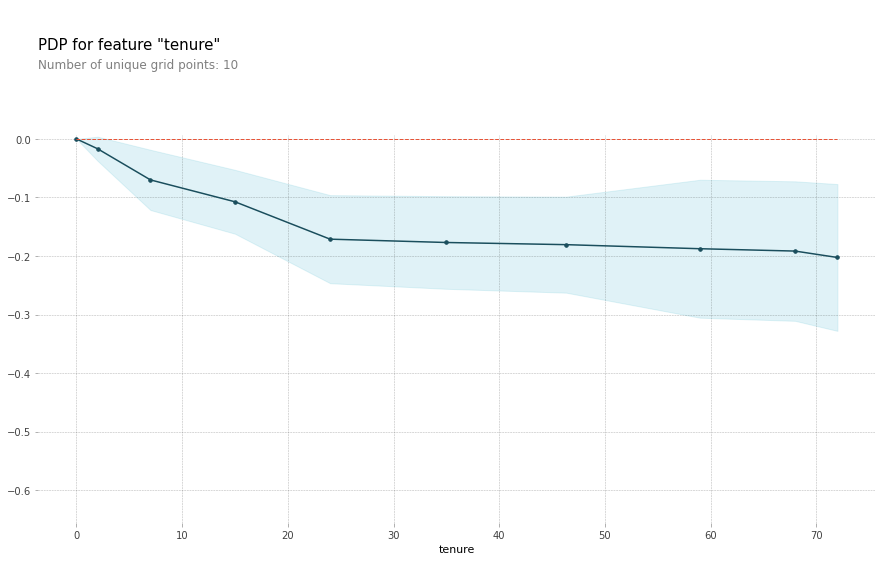

In [25]:
from pdpbox.pdp import pdp_isolate, pdp_plot

isolated = pdp_isolate(
    model=model_xgb,
    dataset=X_val, 
    model_features=X_val_selected.columns, 
    feature=tenure,

)
pdp_plot(isolated, feature_name=tenure);


**Contract** 특성

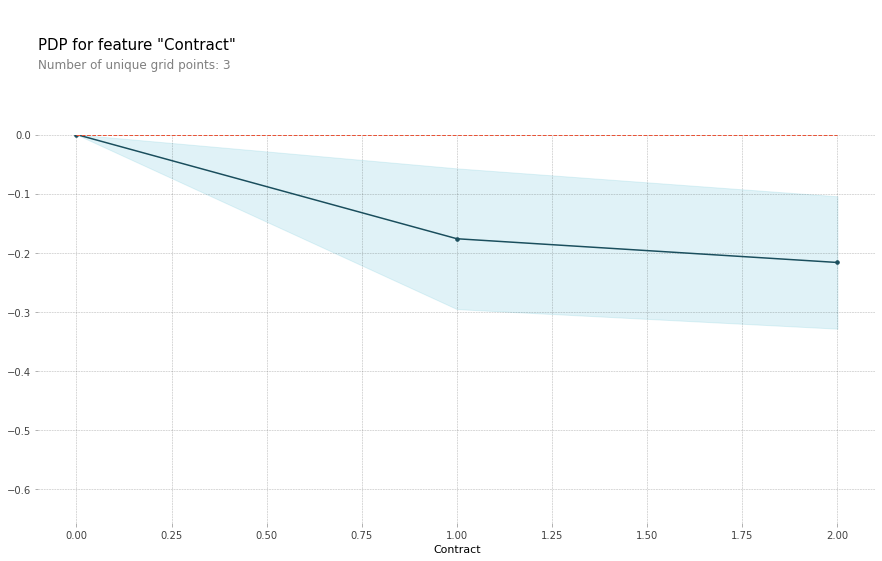

In [29]:
contract = 'Contract'
isolated2 = pdp_isolate(
    model=model_xgb,
    dataset=X_val, 
    model_features=X_val_selected.columns, 
    feature=contract,

)
pdp_plot(isolated2, feature_name=contract);




> SHAP






In [ ]:
processor = make_pipeline(
    OrdinalEncoder(), 
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model_shap = XGBClassifier(
    n_estimators=310,min_samples_split=3,max_features=6,max_depth=8,num_iterations=300,
    random_state=2,verbose=10, n_jobs=-1, scale_pos_weight=ratio,cv=3,
    scoring='accuracy',return_train_score=True)

model_shap.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)



> Force plot



case 1

In [ ]:
row = X_train_processed.iloc[[1]]
row

In [ ]:
import shap

explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

case 2

In [ ]:
row2 = X_train_processed.iloc[[50]]
row2

In [ ]:
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(row2)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row2
)


> Summary plot : scatter, violin, bar



In [ ]:
shap.initjs()
rows = X_train_processed
shap_values = explainer.shap_values(rows)
shap.summary_plot(shap_values, rows)

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, rows, plot_type='violin')

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, rows,plot_type='bar')

각 변수의 shap value에 절대값을 취해서 나타낸 그래프로, 특성의 평균적인 영향력을 보여주는 그래프입니다. bar의 길이가 길수록 타겟과의 관계성이 높다는 것을 나타내기 때문에, 이 그래프는 특성 중요도 그래프와 같은 결과를 보여준다는 것을 알 수 있습니다.